In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the paths to the data directories
data_dir = r'C:\Games\FaceCut-HairAdvisor\data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Data transformations (resize, normalize, augment)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Create data loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

# Get class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Define the model (using pretrained ResNet18)
model = models.resnet18(pretrained=True)

# Freeze the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for gender classification (2 classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

# Training the model
# Training the model
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress for every 10 batches
                if i % 10 == 0:
                    print(f'[{phase}] Epoch {epoch+1}/{num_epochs}, Batch {i}, Loss: {loss.item():.4f}')

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Train the model
trained_model = train_model(model, criterion, optimizer, num_epochs=3)


# Save the trained model
torch.save(trained_model.state_dict(), 'gender_classification_model.pth')

# Testing the model on test set
def test_model(model):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(image_datasets['test'])
    print(f'Test Accuracy: {test_acc:.4f}')

# Test the model
test_model(trained_model)


Epoch 1/3
----------
[train] Epoch 1/3, Batch 0, Loss: 1.2262
[train] Epoch 1/3, Batch 10, Loss: 0.3462
[train] Epoch 1/3, Batch 20, Loss: 0.2349
[train] Epoch 1/3, Batch 30, Loss: 0.3206
[train] Epoch 1/3, Batch 40, Loss: 0.1780
[train] Epoch 1/3, Batch 50, Loss: 0.1266
[train] Epoch 1/3, Batch 60, Loss: 0.4094
[train] Epoch 1/3, Batch 70, Loss: 0.1968
[train] Epoch 1/3, Batch 80, Loss: 0.1074
[train] Epoch 1/3, Batch 90, Loss: 0.0803
[train] Epoch 1/3, Batch 100, Loss: 0.2562
[train] Epoch 1/3, Batch 110, Loss: 0.4886
[train] Epoch 1/3, Batch 120, Loss: 0.1880
[train] Epoch 1/3, Batch 130, Loss: 0.2539
[train] Epoch 1/3, Batch 140, Loss: 0.0777
[train] Epoch 1/3, Batch 150, Loss: 0.1466
[train] Epoch 1/3, Batch 160, Loss: 0.4848
[train] Epoch 1/3, Batch 170, Loss: 0.2354
[train] Epoch 1/3, Batch 180, Loss: 0.3738
[train] Epoch 1/3, Batch 190, Loss: 0.0183
[train] Epoch 1/3, Batch 200, Loss: 0.5698
[train] Epoch 1/3, Batch 210, Loss: 0.3883
[train] Epoch 1/3, Batch 220, Loss: 0.1033
[

Confusion matrix, without normalization
[[768  11]
 [113 662]]


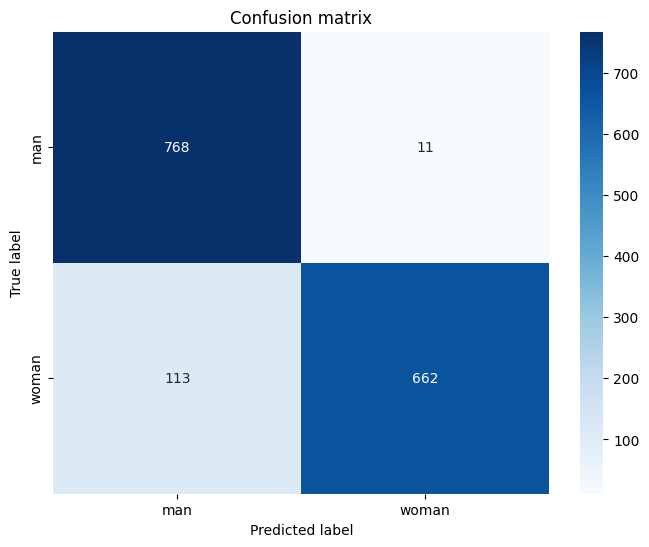

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to test the model and generate the confusion matrix
def test_model_with_confusion_matrix(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Flatten the list of predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, class_names)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Test the model and show the confusion matrix
test_model_with_confusion_matrix(trained_model)
